## 使用决策树和随机森林预测员工离职率
帮助人事部门理解员工为和离职，预测一个员工离职的可能性

## 获取数据

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

In [3]:
df = pd.read_csv('HR_comma_sep.csv', index_col=None)

## 数据预处理

In [4]:
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# 重命名
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [20]:
# 将预测标签“是否离职‘放在第一列
front = df['turnover']
df.drop(labels=['turnover'], axis=1, inplace=True)
df.insert(0, 'turnover', front)
df.tail()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
14994,1,0.40,0.57,2,151,3,0,0,support,low
14995,1,0.37,0.48,2,160,3,0,0,support,low
14996,1,0.37,0.53,2,143,3,0,0,support,low
14997,1,0.11,0.96,6,280,4,0,0,support,low
14998,1,0.37,0.52,2,158,3,0,0,support,low


## 分析数据
- 14999 条数据，每一条数据包含 10 个特征
- 总的离职率 24%
- 平均满意度 0.61

In [9]:
turnover_rate = df.turnover.value_counts() / len(df)
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [10]:
df.describe()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [11]:
# 分组的平均数据统计
turnover_Summary = df.groupby('turnover')
turnover_Summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


##  相关性分析
***
**正相关的特征:** 
- projectCount VS evaluation: 0.349333
- projectCount VS averageMonthlyHours:  0.417211
- averageMonthlyHours VS evaluation: 0.339742

**负相关的特征:**
 - satisfaction VS turnover:  -0.388375

**思考:**
- 什么特征的影响最大?
- 什么特征之间相关性最大?

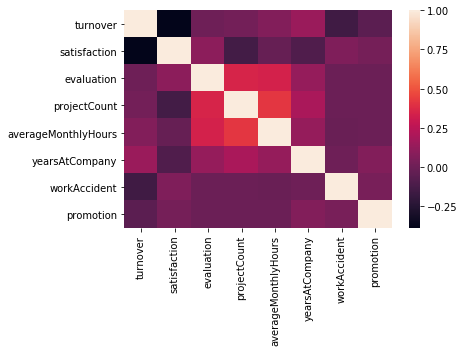

In [13]:
corr = df.corr()
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

## 比较离职和未离职员工的满意度

In [21]:
emp_not_satisfaction = df['satisfaction'][df['turnover']==0].mean()
emp_turnover_satisfaction = df[df['turnover']==1]['satisfaction'].mean()

print('未离职员工满意度: ' + str(emp_not_satisfaction))
print('离职员工满意度: ' + str(emp_turnover_satisfaction))

未离职员工满意度: 0.666809590479516
离职员工满意度: 0.44009801176140917


## 进行 T-Test
进行一个 t-test, 看离职员工的满意度是不是和未来离职员工的满意度明显不同

In [22]:
import scipy.stats as stats
stats.ttest_1samp(a = df[df['turnover']==1]['satisfaction']
                  , popmean = emp_not_satisfaction)

Ttest_1sampResult(statistic=-51.3303486754725, pvalue=0.0)

In [23]:
degree_freedom = len(df[df['turnover']==1])

LQ = stats.t.ppf(0.025, degree_freedom)
RQ = stats.t.ppf(0.975, degree_freedom)

print ('The t-分布 左边界: ' + str(LQ))
print ('The t-分布 右边界: ' + str(RQ))

The t-分布 左边界: -1.9606285215955626
The t-分布 右边界: 1.9606285215955621


## 评测对员工离职，概率密度函数估计

Text(0.5, 1.0, 'Employee Evaluation Distribution - Trunover V.S. No Turnover')

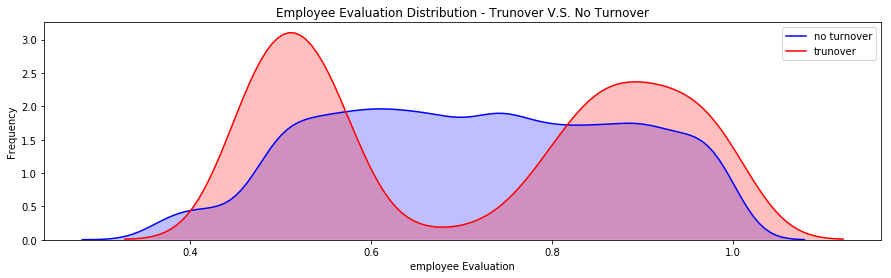

In [24]:
fig = plt.figure(figsize=(15,4),)
ax = sns.kdeplot(df.loc[(df['turnover'] == 0), 'evaluation']
                 , color = 'b', shade=True, label='no turnover')
ax = sns.kdeplot(df.loc[(df['turnover'] == 1), 'evaluation']
                 , color = 'r', shade=True, label='trunover')

ax.set(xlabel='employee Evaluation', ylabel='Frequency')

plt.title('Employee Evaluation Distribution - Trunover V.S. No Turnover')

## 平均每月时间， 概率密度函数估计

Text(0.5, 1.0, 'Employee AverageMonthly Hours Distribution - Turnover V.S No Turnover')

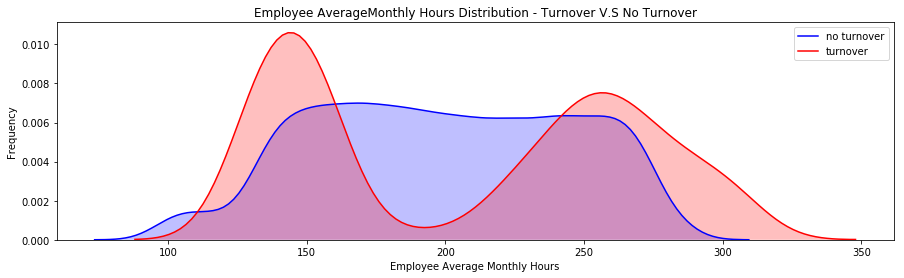

In [28]:
fig = plt.figure(figsize = (15, 4))
ax = sns.kdeplot(df.loc[(df['turnover'] == 0), 'averageMonthlyHours']
                , color='b', shade=True, label = 'no turnover')
ax = sns.kdeplot(df.loc[(df['turnover'] == 1), 'averageMonthlyHours']
                , color='r', shade=True, label = 'turnover')

ax.set(xlabel='Employee Average Monthly Hours', ylabel='Frequency')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S No Turnover')

## 满意度，概率密度估计

Text(0.5, 1.0, 'Employee AverageMonthly Hours Distribution - Turnover V.S No Turnover')

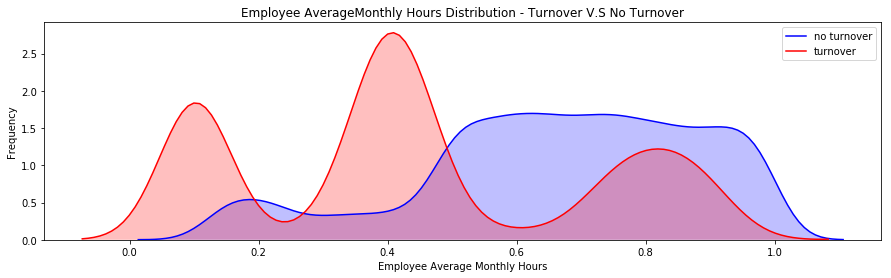

In [29]:
fig = plt.figure(figsize = (15, 4))
ax = sns.kdeplot(df.loc[(df['turnover'] == 0), 'satisfaction']
                , color='b', shade=True, label = 'no turnover')
ax = sns.kdeplot(df.loc[(df['turnover'] == 1), 'satisfaction']
                , color='r', shade=True, label = 'turnover')

ax.set(xlabel='Employee Average Monthly Hours', ylabel='Frequency')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S No Turnover')

## 拆分数据集

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

# 将string类型转换为整数类型
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

# 产生X, y
target_name = 'turnover'
X = df.drop('turnover', axis=1)
y = df[target_name]

# 将数据分为训练和测试数据集
# 注意参数 stratify = y 意味着在产生训练和测试数据中, 离职的员工的百分比等于原来总的数据中的离职的员工的百分比
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

## 随机森林和决策树比较

In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 决策树
dtree = DecisionTreeClassifier(
        criterion = 'entropy',
        # 定义树的深度, 可以用来防止过拟合
        max_depth=10, 
        # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
        min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train, y_train)
print("\n\n ---决策树---")
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print("决策树 AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))

# 随机森林
rf = RandomForestClassifier(
    criterion = 'entropy',
    n_estimators=1000,
    # 定义树的深度, 可以用来防止过拟合
    max_depth=None,
    # 定义至少多少个样本的情况下才继续分叉
    min_samples_split=10,
    # 定义叶子节点最少需要包含多少个样本(使用百分比表达)， 防止过拟合
    # min_weight_fraction_leaf=0.01
    )
rf.fit(X_train, y_train)
print("\n\n ---随机森林---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print("随机森林 AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))

NameError: name 'X_train' is not defined

## ROC 图

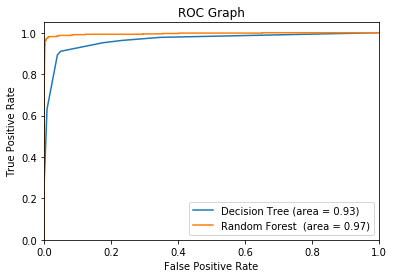

In [44]:
from sklearn.metrics import roc_curve

#  决策树
dtree_fpr, dtree_tpr, dtree_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:, 1])
## 随机森林
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.figure()

# 决策树 ROC
plt.plot(dtree_fpr, dtree_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

# 随机森林 ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest  (area = %0.2f)' % rf_roc_auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc='lower right')
plt.show()

## 通过决策树分析不同的特征的重要性

### 画出随机森林的特征的重要性

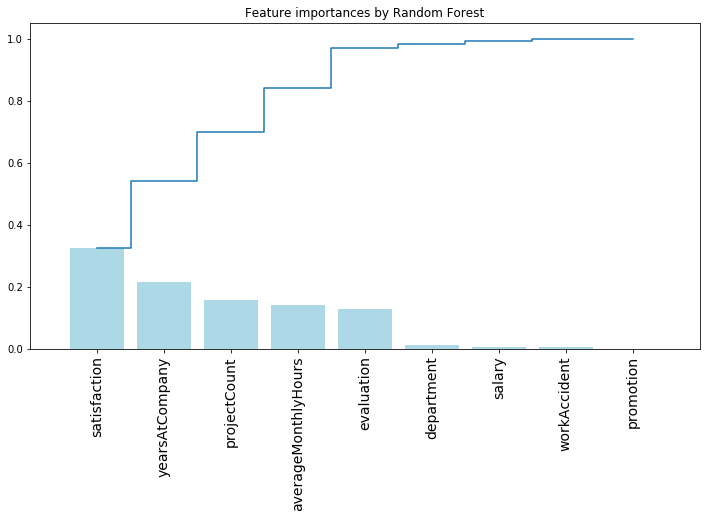

In [45]:

importances = rf.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by Random Forest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [47]:
### 画出决策树特征的重要性

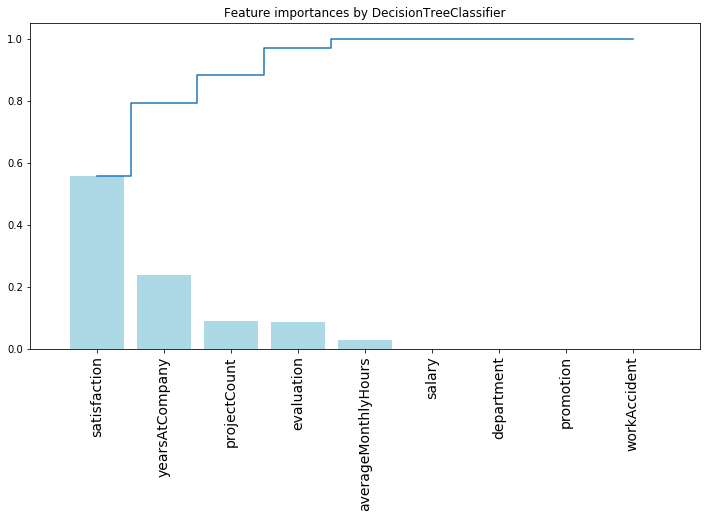

In [48]:
importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

NameError: name 'dtree' is not defined